$\textbf{Training testing code for CIFAR-10 Code}$

In [1]:
# Form the cobweb tree used for centoid/evaluation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import untils  # Provided utility
from DeepTaxonNet import CobwebNN, CobwebNNTreeLayer, TestModel
from torchvision import datasets, transforms

##############################################################################
# SETUP
##############################################################################
# For CIFAR10, we create a transform that ensures images are 32x32.
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((32, 32))
# ])
# batch_size = 128
# n_layers = 10
# # Here, we want a latent dimension of 256, so n_hidden = 256.
# n_hidden = 256

# # IMPORTANT: For CIFAR10, images are 3-channel. Therefore, we use image_shape=(3,32,32)
# cobweb = CobwebNN(image_shape=(3,32,32), n_layers=n_layers, n_hidden=n_hidden)

# optimizer = optim.Adam(cobweb.parameters(), lr=1e-3)

# train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
# test_dataset  = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# epochs = 10
# all_losses = []

##############################################################################
# TRAIN
##############################################################################
# print("[INFO] Training CobwebNN (lambda=10 in cross_entropy_regularization) ...")
# for epoch in range(epochs):
#     for j, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
#         optimizer.zero_grad()
#         # Forward pass using cobweb; note that the output x is the reconstructed input.
#         x, means, logvars, x_preds, p_x_nodes, p_node_xs = cobweb(data)
#         loss = 0
#         for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(
#             zip(means, logvars, x_preds, p_x_nodes, p_node_xs)
#         ):
#             # For CIFAR10, we compare the reconstructed image (flattened to 3*32*32 = 3072)
#             REC = F.mse_loss(
#                 x_pred.view(-1, 3 * 32 * 32),
#                 data.view(-1, 3 * 32 * 32)
#             )
#             # Cross-entropy regularization with lambda=10
#             KL = untils.cross_entropy_regularization(
#                 p_node_x, depth=n_layers - i, lambda_=10
#             )
#             loss += (REC + KL)
#         loss.backward()
#         optimizer.step()
#         all_losses.append(loss.item())
#     print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")

# print("[INFO] Training complete.\n")


In [2]:
# load cifar-10
train_loader, test_loader, train_data, test_data = untils.get_data_loader('cifar-10', 128, False)

In [3]:
# define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
n_layers = 8
n_hidden = 512
image_shape = (3, 32, 32)
image_shape_prod = image_shape[0] * image_shape[1] * image_shape[2]
cobweb = CobwebNN(image_shape=image_shape, n_layers=n_layers, n_hidden=n_hidden,
                  disable_decoder_sigmoid=False
                  ).to(device)

# load model form checkpoins
MODEL_SAVE_PATH_PREFIX = '/home/zwang910/file_storage/nips-2025/deep-taxon/project-checkin'
model_path = 'mse-tree-loss'
cpt_path = 'deep_taxon_400.pt'
model_weights = torch.load(f"{MODEL_SAVE_PATH_PREFIX}/{model_path}/{cpt_path}")
# load model weights
print(model_weights.keys())
cobweb.load_state_dict(model_weights)
# model_weights

odict_keys(['leaves', 'leaves_logvar', 'layers.0.cluster_weight', 'layers.1.cluster_weight', 'layers.2.cluster_weight', 'layers.3.cluster_weight', 'layers.4.cluster_weight', 'layers.5.cluster_weight', 'layers.6.cluster_weight', 'layers.7.cluster_weight', 'encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.1.conv1.weight', 'encoder.layer1.1.bn1.weight', 'encoder.layer1.1.bn1.bias', 'encoder.layer1.1.bn1.running_mean', 'encoder.layer1.1.bn1.running_var', 'en

<All keys matched successfully>

tensor(-0.0001) tensor(0.0226)
tensor(-0.1025) tensor(0.1353)
(1007, 2)


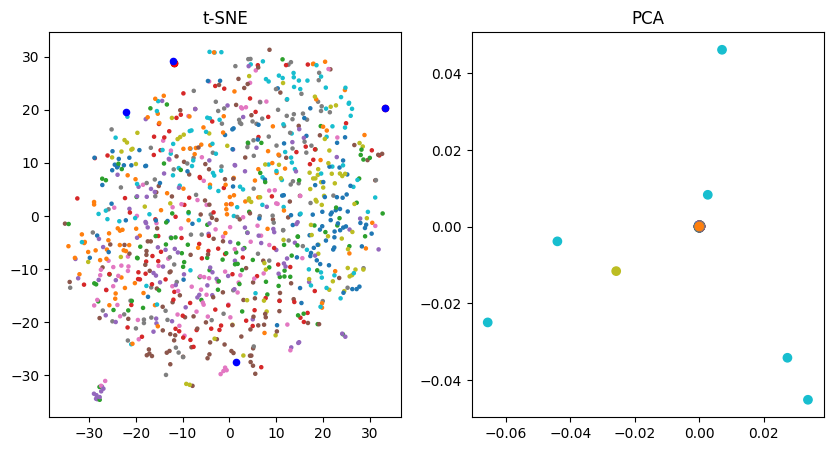

In [4]:
untils.viz_clusters(cobweb, test_data, device=device, n_data=1000)

In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment  # if you wish to use Hungarian later

# ================================
# 1. Compute True Prototypes in Latent Space
# ================================
def compute_true_prototypes_latent(cobweb, train_loader, device):
    """
    For each class (CIFAR10 has 10 classes), pass training images through the encoder and
    fully connected layer to get latent vectors. Then average these latent vectors for each
    class to obtain a true prototype.
    """
    true_sums = {c: torch.zeros(cobweb.n_hidden, device=device) for c in range(10)}
    true_counts = {c: 0 for c in range(10)}
    cobweb.eval()
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc="Computing True Prototypes"):
            data, target = data.to(device), target.to(device)
            # Compute latent representation:
            # latents = cobweb.encoder_fc(cobweb.encoder(data).view(data.size(0), -1))
            latents = cobweb.encoder(data).view(-1, cobweb.n_hidden)
            # latents = cobweb.pre_quantization_conv(latents).view(-1, cobweb.n_hidden)
            for vec, label in zip(latents, target):
                true_sums[label.item()] += vec
                true_counts[label.item()] += 1

    true_centroids = {}
    for c in range(10):
        if true_counts[c] > 0:
            true_centroids[c] = true_sums[c] / true_counts[c]
        else:
            print(f"Warning: No training samples found for class {c}.")
            true_centroids[c] = torch.zeros(cobweb.n_hidden, device=device)
    return true_centroids


In [ ]:
true_centroids = compute_true_prototypes_latent(cobweb, train_loader, device)

Computing True Prototypes:  15%|█▌        | 60/391 [00:11<01:00,  5.51it/s]

In [28]:
true_centroids[1].shape

torch.Size([512])

In [41]:
# ================================
# 2. Extract Candidate Prototypes from the Cobweb Tree
# ================================
def extract_candidate_centroids(cobweb, train_loader, device):
    """
    For every node in the Cobweb tree (from every layer), extract its centroid 
    (the "means" output) and concatenate them into one tensor.
    These centroids are in the latent space.
    """
    candidate_list = []
    cobweb.eval()
    with torch.no_grad():
        for data, _ in tqdm(train_loader, desc="Extracting Tree Nodes"):
            data = data.to(device)
            # The cobweb forward pass returns a list "means_list" of node centroids per layer.
            _, means_list, _, _, _, _, _, _ = cobweb(data)
            for layer_means in means_list:
                # layer_means: shape [num_nodes_in_layer, n_hidden]
                candidate_list.append(layer_means.detach().cpu())
            break
    # Concatenate all candidates from all layers and batches.
    all_candidates = torch.cat(candidate_list, dim=0)  # shape: [num_candidates, n_hidden]
    return all_candidates

In [42]:
candidate_centroids = extract_candidate_centroids(cobweb, train_loader, device)
candidate_centroids.shape

Extracting Tree Nodes:   0%|          | 0/391 [00:00<?, ?it/s]


torch.Size([511, 512])

In [43]:
# ================================
# 3. Pick Best Candidates (Matching True to Candidate Prototypes)
# ================================
def pick_best_candidates_latent(true_centroids, candidate_centroids, n_candidates=3):
    """
    For each true prototype (latent vector), compute Euclidean distance to all candidate
    prototypes (from tree nodes) and convert these distances to scores via exp(-distance).
    Then pick the top n_candidates (with highest scores) for each class.
    Returns a dictionary mapping class label to a list of indices (into candidate_centroids).
    """
    # Ensure candidate_centroids is on the same device as the true prototypes.
    device = next(iter(true_centroids.values())).device
    candidate_centroids = candidate_centroids.to(device)  # shape: [num_candidates, n_hidden]
    
    best_candidates = {c: [] for c in range(10)}
    for c in range(10):
        tc = true_centroids[c].to(device)  # shape: [n_hidden]
        # Compute Euclidean distances: result shape [num_candidates]
        dists = torch.norm(candidate_centroids - tc, p=2, dim=1)
        # print(dists.shape)
        # Convert distances to scores via softmax of negative distance:
        # scores = torch.exp(-dists)
        scores = torch.softmax(-dists, dim=0)
        # Ensure we do not ask for more candidates than available:
        # k_actual = min(n_candidates, scores.size(0))
        # if k_actual < n_candidates:
        #     print(f"Warning: Only {k_actual} candidate(s) available for true class {c} (requested {n_candidates}).")
        # topk = torch.topk(scores, k=k_actual, largest=True)
        topk = torch.topk(scores, k=n_candidates, largest=True)
        best_candidates[c] = topk.indices.cpu().tolist()  # these indices refer to candidate_centroids rows
    return best_candidates

In [44]:
n_candidates = 5
best_candidates = pick_best_candidates_latent(true_centroids, candidate_centroids, n_candidates=n_candidates)

In [45]:
# ================================
# 4. Evaluate Top-k Accuracy on Test Set
# ================================
def evaluate_topk_accuracy_latent(cobweb, best_candidates, candidate_centroids, test_loader, device='cpu'):
    """
    For each test sample, compute its latent representation, then compute the distance
    to each of the best candidate prototypes (which have been assigned a class label based on
    the matching in step 3). The candidate's label is the true class of the true prototype
    that selected it. If the test sample's true label is among the top-k candidates (by score),
    count it as correct.
    
    Returns overall accuracy and a dictionary of class-wise accuracies.
    """
    # Build a list of (class_label, candidate_vector) for each best candidate.
    labeled_candidates = []
    for class_label, indices in best_candidates.items():
        print(class_label, indices)
        # for idx in indices:
            # candidate_centroids is assumed to be a tensor in latent space.
        labeled_candidates.append((class_label, candidate_centroids[indices[:]].to(device)))
    
    correct = 0
    total = 0
    class_correct = {c: 0 for c in range(10)}
    class_total = {c: 0 for c in range(10)}

    all_distances = []
    all_labels = []
    
    cobweb.eval()
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            # Compute latent representations for test data.
            # latents = cobweb.encoder_fc(cobweb.encoder(data).view(data.size(0), -1))
            latents = cobweb.encoder(data)
            latents = cobweb.pre_quantization_conv(latents).view(-1, cobweb.n_hidden) # batch_size x n_hidden

            class_distances = []

            for class_label, candidate_centroid in labeled_candidates:
                # print(class_label, candidate_centroid.shape)
                # print(latents.shape)
                dist = torch.norm(latents.unsqueeze(1) - candidate_centroid.unsqueeze(0), p=2, dim=-1) # shape: batch x n_candidates
                # print(dist.shape)
                # print(candidate_centroid.shape)
                # break
                dist = torch.mean(dist, dim=-1)  # shape: batch_size
                class_distances.append(dist)
            class_distances = torch.stack(class_distances, dim=-1)
            all_distances.append(class_distances)
            all_labels.append(targets)

        all_distances = torch.cat(all_distances, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        # print(all_distances.shape)

        pred = torch.argmin(all_distances, dim=-1)
        overall_accuracy = torch.sum(pred == all_labels).item() / len(all_labels)
        class_accuracy = {}
        for c in range(10):
            class_accuracy[c] = torch.sum(pred[all_labels == c] == c).item() / torch.sum(all_labels == c).item()
        # print(pred.shape)

            # print(class_distances.shape)
                # print(dist.shape)

                # break

    #         for latent_vec, true_label in zip(latents, targets):
    #             distances = []
    #             candidate_labels = []
    #             for lab, cand_vec in labeled_candidates:
    #                 dist = torch.norm(latent_vec - cand_vec, p=2).item()
    #                 distances.append(dist)
    #                 candidate_labels.append(lab)
    #             distances = np.array(distances)
    #             # Convert distances to scores via exp(-distance)
    #             # scores = np.exp(-distances)
    #             scores = torch.softmax(-distances, dim=0)
    #             # Select top-k candidate labels (highest scores correspond to lowest distance)
    #             topk_idx = np.argsort(scores)[-k:]
    #             topk_labels = [candidate_labels[i] for i in topk_idx]
    #             if true_label.item() in topk_labels:
    #                 correct += 1
    #                 class_correct[true_label.item()] += 1
    #             total += 1
    #             class_total[true_label.item()] += 1
                
    # overall_accuracy = correct / total
    # class_accuracy = {c: class_correct[c]/class_total[c] if class_total[c] > 0 else 0 for c in range(10)}
    return overall_accuracy, class_accuracy


In [47]:
# k = 3  # top-k candidates to consider during evaluation
overall_acc, class_acc = evaluate_topk_accuracy_latent(cobweb, best_candidates, candidate_centroids, test_loader, device=device)
print(f"Overall accuracy: {overall_acc:.4f}")
for c in range(10):
    print(f"Class {c} accuracy: {class_acc[c]:.4f}")

0 [70, 97, 291, 60, 168]
1 [70, 97, 291, 168, 156]
2 [70, 97, 291, 168, 156]
3 [70, 97, 168, 156, 291]
4 [70, 97, 168, 291, 156]
5 [70, 97, 168, 291, 156]
6 [70, 97, 168, 156, 291]
7 [70, 97, 156, 291, 168]
8 [70, 97, 291, 168, 60]
9 [70, 97, 291, 168, 156]


Evaluating: 100%|██████████| 40/40 [00:00<00:00, 45.59it/s]


Overall accuracy: 0.1294
Class 0 accuracy: 0.6170
Class 1 accuracy: 0.5020
Class 2 accuracy: 0.0000
Class 3 accuracy: 0.0700
Class 4 accuracy: 0.0000
Class 5 accuracy: 0.0000
Class 6 accuracy: 0.0000
Class 7 accuracy: 0.0340
Class 8 accuracy: 0.0710
Class 9 accuracy: 0.0000


In [ ]:
# ================================
# MAIN INTEGRATED PIPELINE
# ================================
if __name__ == "__main__":
    # Set up data loaders and transformation for CIFAR10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32))
    ])
    batch_size = 128
    train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    test_dataset  = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Assume cobweb is a trained instance of CobwebNN
    from COBWEBNN import CobwebNN
    n_layers = 10
    n_hidden = 256
    # For CIFAR10, image_shape is (3,32,32)
    cobweb = CobwebNN(image_shape=(3,32,32), n_layers=n_layers, n_hidden=n_hidden)
    
    # (Optional) load a pretrained model checkpoint here
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cobweb.to(device)
    
    # 1. Compute True Prototypes (latent space)
    true_centroids = compute_true_prototypes_latent(cobweb, train_loader, device)
    
    # 2. Extract Candidate Prototypes from the tree (latent space)
    candidate_centroids = extract_candidate_centroids(cobweb, train_loader, device)
    print("Total candidate centroids extracted:", candidate_centroids.shape[0])
    
    # 3. Pick best candidates (match each true prototype to top-n candidates)
    n_candidates = 3
    best_candidates = pick_best_candidates_latent(true_centroids, candidate_centroids, n_candidates=n_candidates)
    for c in range(10):
        print(f"Best candidates for class {c} (indices in candidate_centroids): {best_candidates[c]}")
    
    # 4. Evaluate the system on the test set
    k = 3  # top-k candidates to consider during evaluation
    overall_acc, class_acc = evaluate_topk_accuracy_latent(cobweb, best_candidates, candidate_centroids, test_loader, k=k, device=device)
    print(f"Overall top-{k} accuracy: {overall_acc:.4f}")
    for c in range(10):
        print(f"Class {c} accuracy: {class_acc[c]:.4f}")

$\textbf{Training testing code for MNIST Configuration}$

In [ ]:
#Use this cell for building out the tree
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
import untils  # Provided utility
from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
from torchvision import datasets, transforms

##############################################################################
# SETUP
##############################################################################
# For MNIST, we create a transform that either replicates the 1-channel to 3 channels,
# or adjust the model accordingly. Here we assume you want to use the native MNIST size.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))  # Ensure MNIST is 28x28
])
batch_size = 128
n_layers = 10
# Here, we want a latent dimension of 256, so n_hidden = 256.
n_hidden = 256

# IMPORTANT: Use an encoder-compatible image_shape.
# If using MNIST (grayscale), we use image_shape=(1,28,28).
cobweb = CobwebNN(image_shape=(1,28,28), n_layers=n_layers, n_hidden=n_hidden)

optimizer = optim.Adam(cobweb.parameters(), lr=1e-3)

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

epochs = 10
all_losses = []

##############################################################################
# TRAIN
##############################################################################
print("[INFO] Training CobwebNN (lambda=10 in cross_entropy_regularization) ...")
for epoch in range(epochs):
    for j, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        # Forward pass using cobweb; note that the output x is the original input.
        x, means, logvars, x_preds, p_x_nodes, p_node_xs = cobweb(data)
        loss = 0
        for i, (mean, logvar, x_pred, p_x_node, p_node_x) in enumerate(
            zip(means, logvars, x_preds, p_x_nodes, p_node_xs)
        ):
            # For MNIST, we compare the reconstructed image (flattened to 28*28)
            REC = F.mse_loss(
                x_pred.view(-1, 28 * 28),
                data.view(-1, 28 * 28)
            )
            # Cross-entropy regularization with lambda=10
            KL = untils.cross_entropy_regularization(
                p_node_x, depth=n_layers - i, lambda_=10
            )
            loss += (REC + KL)
        loss.backward()
        optimizer.step()
        all_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")

print("[INFO] Training complete.\n")

[INFO] Training CobwebNN (lambda=10 in cross_entropy_regularization) ...


  0%|          | 0/469 [00:00<?, ?it/s]/home/ehaarer3/miniconda3/envs/ethan-dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 469/469 [03:12<00:00,  2.43it/s]


Epoch 1/10, Loss = 0.7108


100%|██████████| 469/469 [03:18<00:00,  2.36it/s]


Epoch 2/10, Loss = 0.5802


100%|██████████| 469/469 [03:19<00:00,  2.35it/s]


Epoch 3/10, Loss = 0.5123


100%|██████████| 469/469 [03:12<00:00,  2.44it/s]


Epoch 4/10, Loss = 0.4846


100%|██████████| 469/469 [03:16<00:00,  2.38it/s]


Epoch 5/10, Loss = 0.4456


100%|██████████| 469/469 [03:22<00:00,  2.32it/s]


Epoch 6/10, Loss = 0.4330


100%|██████████| 469/469 [03:20<00:00,  2.34it/s]


Epoch 7/10, Loss = 0.4162


100%|██████████| 469/469 [03:16<00:00,  2.38it/s]


Epoch 8/10, Loss = 0.4141


100%|██████████| 469/469 [03:16<00:00,  2.38it/s]


Epoch 9/10, Loss = 0.3761


100%|██████████| 469/469 [03:15<00:00,  2.40it/s]

Epoch 10/10, Loss = 0.3735
[INFO] Training complete.



In [78]:
import torch
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment  # if you wish to use Hungarian later

# ================================
# 1. Compute True Prototypes in Latent Space
# ================================
def compute_true_prototypes_latent(cobweb, train_loader, device):
    """
    For each digit class (0-9), pass training images through the encoder and
    fully connected layer to get latent vectors. Then average these latent vectors
    for each class to obtain a true prototype.
    """
    true_sums = {c: torch.zeros(cobweb.n_hidden, device=device) for c in range(10)}
    true_counts = {c: 0 for c in range(10)}
    cobweb.eval()
    with torch.no_grad():
        for data, target in tqdm(train_loader, desc="Computing True Prototypes"):
            data, target = data.to(device), target.to(device)
            # Compute latent representation:
            latents = cobweb.encoder_fc(cobweb.encoder(data).view(data.size(0), -1))
            for vec, label in zip(latents, target):
                true_sums[label.item()] += vec
                true_counts[label.item()] += 1

    true_centroids = {}
    for c in range(10):
        if true_counts[c] > 0:
            true_centroids[c] = true_sums[c] / true_counts[c]
        else:
            true_centroids[c] = torch.zeros(cobweb.n_hidden, device=device)
    return true_centroids

# ================================
# 2. Extract Candidate Prototypes from the Cobweb Tree
# ================================
def extract_candidate_centroids(cobweb, train_loader, device):
    """
    For every node in the Cobweb tree (from every layer), extract its centroid 
    (the "means" output) and concatenate them into one tensor.
    These centroids are in the latent space.
    """
    candidate_list = []
    cobweb.eval()
    with torch.no_grad():
        for data, _ in tqdm(train_loader, desc="Extracting Tree Nodes"):
            data = data.to(device)
            # The cobweb forward pass returns a list "means_list" of node centroids per layer.
            _, means_list, _, _, _, _ = cobweb(data)
            for layer_means in means_list:
                # layer_means: shape [num_nodes_in_layer, n_hidden]
                candidate_list.append(layer_means.detach().cpu())
    # Concatenate all candidates from all layers and batches.
    all_candidates = torch.cat(candidate_list, dim=0)  # shape: [num_candidates, n_hidden]
    return all_candidates

# ================================
# 3. Pick Best Candidates (Matching True to Candidate Prototypes)
# ================================
def pick_best_candidates_latent(true_centroids, candidate_centroids, n_candidates=3):
    """
    For each true prototype (latent vector), compute Euclidean distance to all candidate
    prototypes (from tree nodes) and convert these distances to scores via exp(-distance).
    Then pick the top n_candidates (with highest scores) for each class.
    Returns a dictionary mapping class label to a list of indices (into candidate_centroids).
    """
    # Ensure candidate_centroids is on the same device as the true prototypes.
    device = next(iter(true_centroids.values())).device
    candidate_centroids = candidate_centroids.to(device)  # shape: [num_candidates, n_hidden]
    
    best_candidates = {c: [] for c in range(10)}
    for c in range(10):
        tc = true_centroids[c].to(device)  # shape: [n_hidden]
        # Compute Euclidean distances: result shape [num_candidates]
        dists = torch.norm(candidate_centroids - tc, p=2, dim=1)
        # Convert distances to scores via softmax of negative distance:
        scores = torch.exp(-dists)
        # Ensure we do not ask for more candidates than available:
        k_actual = min(n_candidates, scores.size(0))
        if k_actual < n_candidates:
            print(f"Warning: Only {k_actual} candidate(s) available for true class {c} (requested {n_candidates}).")
        topk = torch.topk(scores, k=k_actual, largest=True)
        best_candidates[c] = topk.indices.cpu().tolist()  # these indices refer to candidate_centroids rows
    return best_candidates

# ================================
# 4. Evaluate Top-k Accuracy on Test Set
# ================================
def evaluate_topk_accuracy_latent(cobweb, best_candidates, candidate_centroids, test_loader, k=3, device='cpu'):
    """
    For each test sample, compute its latent representation, then compute the distance
    to each of the best candidate prototypes (which have been assigned a class label based on
    the matching in step 3). The candidate's label is the true class of the true prototype
    that selected it. If the test sample's true label is among the top-k candidates (by score),
    count it as correct.
    
    Returns overall accuracy and a dictionary of class-wise accuracies.
    """
    # Build a list of (class_label, candidate_vector) for each best candidate.
    labeled_candidates = []
    for class_label, indices in best_candidates.items():
        for idx in indices:
            # candidate_centroids is assumed to be a tensor in latent space.
            labeled_candidates.append((class_label, candidate_centroids[idx].to(device)))
    
    correct = 0
    total = 0
    class_correct = {c: 0 for c in range(10)}
    class_total = {c: 0 for c in range(10)}
    
    cobweb.eval()
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc="Evaluating"):
            data, targets = data.to(device), targets.to(device)
            # Compute latent representations for test data.
            latents = cobweb.encoder_fc(cobweb.encoder(data).view(data.size(0), -1))
            for latent_vec, true_label in zip(latents, targets):
                distances = []
                candidate_labels = []
                for lab, cand_vec in labeled_candidates:
                    dist = torch.norm(latent_vec - cand_vec, p=2).item()
                    distances.append(dist)
                    candidate_labels.append(lab)
                distances = np.array(distances)
                # Convert distances to scores via exp(-distance)
                scores = np.exp(-distances)
                # Select top-k candidate labels (highest scores correspond to lowest distance)
                topk_idx = np.argsort(scores)[-k:]
                topk_labels = [candidate_labels[i] for i in topk_idx]
                if true_label.item() in topk_labels:
                    correct += 1
                    class_correct[true_label.item()] += 1
                total += 1
                class_total[true_label.item()] += 1
                
    overall_accuracy = correct / total
    class_accuracy = {c: class_correct[c]/class_total[c] if class_total[c] > 0 else 0 for c in range(10)}
    return overall_accuracy, class_accuracy

# ================================
# MAIN INTEGRATED PIPELINE
# ================================
if __name__ == "__main__":
    # Set up data loaders and transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28))
    ])
    batch_size = 128
    train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Assume cobweb is a trained instance of CobwebNN
    from COBWEBNN import CobwebNN
    n_layers = 10
    n_hidden = 256
    cobweb = CobwebNN(image_shape=(1,28,28), n_layers=n_layers, n_hidden=n_hidden)
    
    # (Optional) load a pretrained model checkpoint here
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cobweb.to(device)
    
    # 1. Compute True Prototypes (latent space)
    true_centroids = compute_true_prototypes_latent(cobweb, train_loader, device)
    
    # 2. Extract Candidate Prototypes from the tree (latent space)
    candidate_centroids = extract_candidate_centroids(cobweb, train_loader, device)
    print("Total candidate centroids extracted:", candidate_centroids.shape[0])
    
    # 3. Pick best candidates (match each true prototype to top-n candidates)
    n_candidates = 3
    best_candidates = pick_best_candidates_latent(true_centroids, candidate_centroids, n_candidates=n_candidates)
    for c in range(10):
        print(f"Best candidates for class {c} (indices in candidate_centroids): {best_candidates[c]}")
    
    # 4. Evaluate the system on the test set
    k = 3  # top-k candidates to consider during evaluation
    overall_acc, class_acc = evaluate_topk_accuracy_latent(cobweb, best_candidates, candidate_centroids, test_loader, k=k, device=device)
    print(f"Overall top-{k} accuracy: {overall_acc:.4f}")
    for c in range(10):
        print(f"Class {c} accuracy: {class_acc[c]:.4f}")


Extracting Tree Nodes: 100%|██████████| 469/469 [00:15<00:00, 30.55it/s]


Total candidate centroids extracted: 960043
Best candidates for class 0 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 1 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 2 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 3 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 4 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 5 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 6 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 7 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 8 (indices in candidate_centroids): [6140, 4093, 2046]
Best candidates for class 9 (indices in candidate_centroids): [6140, 4093, 2046]


Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.44it/s]

Overall top-3 accuracy: 0.1989
Class 0 accuracy: 1.0000
Class 1 accuracy: 0.0000
Class 2 accuracy: 0.0000
Class 3 accuracy: 0.0000
Class 4 accuracy: 0.0000
Class 5 accuracy: 0.0000
Class 6 accuracy: 0.0000
Class 7 accuracy: 0.0000
Class 8 accuracy: 0.0000
Class 9 accuracy: 1.0000


In [ ]:
#This one has problems grabbing nodes for the candidates
# import torch
# import torch.nn.functional as F
# import numpy as np
# from collections import defaultdict
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# from scipy.optimize import linear_sum_assignment

# # --------------------------------------------------------
# # 1. True Class Centroids
# # --------------------------------------------------------
# def compute_true_class_centroids(train_loader):
#     """
#     Compute 10 'true' prototypes by averaging all images in the raw pixel space (28x28).
#     Returns a dict: { digit_label: centroid_image (28x28) }
#     """
#     images_by_class = defaultdict(list)
#     for data, target in train_loader:
#         # data shape: [batch_size, 1, 28, 28]
#         # target shape: [batch_size]
#         for img, label in zip(data, target):
#             images_by_class[label.item()].append(img.squeeze(0))  # shape [28,28]

#     true_centroids = {}
#     for c in range(10):
#         # Stack all images for class c
#         class_images = torch.stack(images_by_class[c], dim=0)  # shape [N_c, 28, 28]
#         # Compute pixel-wise mean
#         centroid = class_images.mean(dim=0)  # shape [28,28]
#         true_centroids[c] = centroid

#     return true_centroids

# # --------------------------------------------------------
# # 2. Candidate Prototypes from Cobweb Tree
# # --------------------------------------------------------
# def compute_candidate_centroids(cobweb, train_loader, device):
#     """
#     For every node in the Cobweb tree, compute its centroid (in raw pixel space or latent).
#     We'll do raw pixel space for demonstration. If you want latent space, pass data through
#     cobweb.encoder -> cobweb.encoder_fc first.
    
#     We assume we have a method to get node IDs for each sample. 
#     If not, we create a dictionary node_id -> (sum_of_images, count).
#     """
#     # A dictionary from node_id -> (sum_of_images, count)
#     node_sums = defaultdict(lambda: torch.zeros((28, 28), device=device))
#     node_counts = defaultdict(int)

#     cobweb.eval()
#     with torch.no_grad():
#         for data, _ in train_loader:
#             data = data.to(device)
#             # We'll do a hypothetical "node_assignments = cobweb.get_node_assignments(data)"
#             # which should return a list of node IDs, one per sample in data
#             # For demonstration, let's assume everything goes to a single node '0'
#             # In practice, you'd need to implement logic that finds the best node for each sample
#             node_assignments = [0]*len(data)  # REPLACE with your actual method

#             for img, node_id in zip(data, node_assignments):
#                 node_sums[node_id] += img.squeeze(0)  # shape [28,28]
#                 node_counts[node_id] += 1

#     # Now compute centroids for each node
#     candidate_centroids = {}
#     for node_id, sum_img in node_sums.items():
#         ccount = node_counts[node_id]
#         if ccount > 0:
#             candidate_centroids[node_id] = sum_img / ccount
#         else:
#             candidate_centroids[node_id] = torch.zeros((28,28), device=device)

#     return candidate_centroids


# # --------------------------------------------------------
# # 3. Match n_candidates for each True Prototype (Hungarian)
# # --------------------------------------------------------
# # def pick_best_candidates(true_centroids, candidate_centroids, n_candidates=3):
# #     """
# #     Matches true centroids to candidate centroids.
# #     Ensures that all tensors are on the same device.
# #     """
# #     # Get the device from one of the true centroids
# #     device = next(iter(true_centroids.values())).device

# #     all_node_ids = list(candidate_centroids.keys())
# #     # Move all candidate centroids to the same device as the true centroids
# #     all_node_imgs = torch.stack([candidate_centroids[nid].to(device) for nid in all_node_ids], dim=0)  # shape [num_nodes, 28, 28]

# #     best_candidates = {c: [] for c in range(10)}

# #     for c in range(10):
# #         tc = true_centroids[c].to(device).unsqueeze(0)  # shape [1, 28,28]
# #         # Euclidean distance to each candidate
# #         dist = torch.norm(all_node_imgs - tc, p=2, dim=(1,2))  # shape [num_nodes]
# #         # Use softmax of negative distances as scores
# #         scores = torch.exp(-dist)
# #         # pick top-n with highest score (lowest distance)
# #         topk = torch.topk(scores, k=n_candidates, largest=True)
# #         indices = topk.indices  # shape [n_candidates]
# #         node_ids_for_c = [all_node_ids[idx.item()] for idx in indices]
# #         best_candidates[c] = node_ids_for_c

# #     return best_candidates


# def pick_best_candidates(true_centroids, candidate_centroids, n_candidates=3):
#     """
#     Matches true centroids to candidate centroids.
#     Ensures that all tensors are on the same device.
#     If the number of candidate centroids is less than n_candidates, uses all available candidates.
#     """
#     # Get the device from one of the true centroids
#     device = next(iter(true_centroids.values())).device

#     all_node_ids = list(candidate_centroids.keys())
#     # Move all candidate centroids to the same device as the true centroids
#     all_node_imgs = torch.stack([candidate_centroids[nid].to(device) for nid in all_node_ids], dim=0)  # shape [num_nodes, 28, 28]

#     best_candidates = {c: [] for c in range(10)}

#     for c in range(10):
#         tc = true_centroids[c].to(device).unsqueeze(0)  # shape [1, 28,28]
#         # Euclidean distance to each candidate
#         dist = torch.norm(all_node_imgs - tc, p=2, dim=(1,2))  # shape [num_nodes]
#         scores = torch.exp(-dist)
        
#         # Use the actual available number of candidates if fewer than n_candidates exist
#         k_actual = min(n_candidates, scores.size(0))
#         if k_actual < n_candidates:
#             print(f"Warning: Only {k_actual} candidate(s) available for true class {c} (requested {n_candidates}).")
        
#         topk = torch.topk(scores, k=k_actual, largest=True)
#         indices = topk.indices  # shape [k_actual]
#         node_ids_for_c = [all_node_ids[idx.item()] for idx in indices]
#         best_candidates[c] = node_ids_for_c

#     return best_candidates

# # --------------------------------------------------------
# # 4. Evaluate on Test Set (Top-k Accuracy)
# # --------------------------------------------------------
# def evaluate_topk_accuracy(best_candidates, candidate_centroids, test_loader, k=3, device='cpu'):
#     """
#     best_candidates: dict {class_label: [node_ids...]} - top-n candidates for each class
#     candidate_centroids: dict {node_id: tensor(28,28)}
#     test_loader: the test set
#     k: top-k
#     """
#     # Build a single list of (class_label, node_id, node_img)
#     # We'll need these to do a final top-k classification
#     labeled_candidates = []
#     for class_label, node_ids in best_candidates.items():
#         for nid in node_ids:
#             labeled_candidates.append((class_label, nid, candidate_centroids[nid]))

#     # We'll have 10*n_candidates total
#     # Evaluate
#     correct = 0
#     total = 0

#     # Also track class-wise
#     class_correct = {c: 0 for c in range(10)}
#     class_total = {c: 0 for c in range(10)}

#     with torch.no_grad():
#         for data, targets in test_loader:
#             data, targets = data.to(device), targets.to(device)
#             # data shape: [batch_size, 1, 28, 28]
#             B = data.shape[0]

#             # Flatten or keep shape to compute distance
#             # shape [B, 28,28]
#             data_reshaped = data.squeeze(1)

#             # We'll compute distance from each sample to each candidate
#             # labeled_candidates is length (10*n_candidates)
#             # We'll do a loop or vectorization
#             for i in range(B):
#                 sample = data_reshaped[i]
#                 label = targets[i].item()

#                 # Distances to each candidate
#                 # candidate_img shape [28,28]
#                 distances = []
#                 cand_labels = []
#                 for (clabel, nid, cand_img) in labeled_candidates:
#                     dist = torch.norm(sample - cand_img, p=2).item()
#                     distances.append(dist)
#                     cand_labels.append(clabel)

#                 distances = np.array(distances)
#                 # turn them into softmax-of-negative-dist
#                 neg_dist = -distances
#                 exp_neg = np.exp(neg_dist)
#                 scores = exp_neg / np.sum(exp_neg)

#                 # get top-k
#                 topk_idx = np.argsort(scores)[-k:]
#                 topk_labels = [cand_labels[idx] for idx in topk_idx]

#                 if label in topk_labels:
#                     correct += 1
#                     class_correct[label] += 1
#                 total += 1
#                 class_total[label] += 1

#     overall_accuracy = correct / total
#     class_accuracy = {}
#     for c in range(10):
#         if class_total[c] == 0:
#             class_accuracy[c] = 0
#         else:
#             class_accuracy[c] = class_correct[c] / class_total[c]

#     return overall_accuracy, class_accuracy


# # =========================
# # EXAMPLE USAGE
# # =========================
# if __name__ == "__main__":
#     # We'll do a quick demonstration with the raw dataset. 
#     # Adjust to your environment as needed.
#     transform = transforms.Compose([
#         transforms.ToTensor()
#     ])
#     train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
#     test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
#     # Suppose you have a trained cobweb model
#     # cobweb = ...
#     # cobweb.to(device)

#     # 1. TRUE PROTOTYPES
#     true_centroids = compute_true_class_centroids(train_loader)

#     # 2. CANDIDATE PROTOTYPES
#     # We'll pretend compute_candidate_centroids returns a dict {node_id: [28,28] tensor}
#     candidate_centroids = compute_candidate_centroids(cobweb, train_loader, device)  # pass cobweb if needed

#     # 3. MATCH n_candidates
#     n_candidates = 3
#     best_candidates = pick_best_candidates(true_centroids, candidate_centroids, n_candidates=n_candidates)

#     # 4. EVALUATE
#     k = 3  # top-k
#     overall_acc, class_acc = evaluate_topk_accuracy(best_candidates, candidate_centroids, test_loader, k=k, device=device)

#     print(f"Overall top-{k} accuracy: {overall_acc:.4f}")
#     for c in range(10):
#         print(f"Class {c} accuracy: {class_acc[c]:.4f}")


In [2]:
#This code is still funky, but works with below visualizations

# import torch
# import numpy as np
# from tqdm import tqdm
# from torch.utils.data import DataLoader
# from scipy.optimize import linear_sum_assignment

# import numpy as np
# import torch
# import torch.nn.functional as F
# from tqdm import tqdm
# from scipy.optimize import linear_sum_assignment

# # Ensure model is in eval mode
# cobweb.eval()

# ##############################################################################
# # STEP 1: Compute True Class Centroids from Training Data (Gaussian Distributions)
# ##############################################################################

# device = next(cobweb.parameters()).device  # ensure we use the same device as the model
# num_clusters = cobweb.leaves.shape[0]      # number of leaf clusters (e.g., 2**n_layers)
# latent_dim = cobweb.n_hidden               # dimensionality of latent space

# # Initialize aggregates on the correct device
# true_sums    = torch.zeros(num_clusters, latent_dim, device=device)
# true_sq_sums = torch.zeros(num_clusters, latent_dim, device=device)
# true_counts  = torch.zeros(num_clusters, device=device)

# # Switch model to evaluation mode and disable grad to gather statistics
# cobweb.eval()
# with torch.no_grad():
#     for batch_data, _ in tqdm(train_loader, desc="Computing True Class Centroids"):  # iterate over all training samples
#         batch_data = batch_data.to(device)
#         # Obtain latent representation for the entire batch
#         latents = cobweb.encoder_fc(cobweb.encoder(batch_data).view(batch_data.size(0), -1))
        
#         # Determine cluster assignment for each sample (nearest cluster centroid in latent space)
#         # Compute Euclidean distance from each latent to every cluster prototype (cobweb.leaves)
#         dists = torch.norm(latents.unsqueeze(1) - cobweb.leaves.unsqueeze(0), dim=2)  # [batch_size, num_clusters]
#         cluster_indices = torch.argmin(dists, dim=1)  # index of closest cluster for each sample
        
#         # Update sums, squared sums, and counts for each cluster
#         for k in range(num_clusters):
#             # Mask for samples assigned to cluster k
#             mask_k = (cluster_indices == k)
#             if mask_k.any():
#                 true_sums[k]    += latents[mask_k].sum(dim=0)
#                 true_sq_sums[k] += (latents[mask_k] ** 2).sum(dim=0)
#                 true_counts[k]  += mask_k.sum()
                
# # Compute true centroids (mean vector for each cluster in latent space)
# true_centroids = true_sums / true_counts.view(-1, 1)

# # Print the first 5 dimensions of each centroid for verification
# for k in range(num_clusters):
#     centroid_sample = true_centroids[k][:5]  # first 5 dims
#     print(f"Centroid {k} first 5 dims: {centroid_sample.cpu().numpy()}")

# # true_sums = {i: torch.zeros(n_hidden, device=cobweb.leaves.device) for i in range(10)}
# # true_sq_sums = {i: torch.zeros(n_hidden, device=cobweb.leaves.device) for i in range(10)}
# # true_counts = {i: 0 for i in range(10)}

# # with torch.no_grad():
# #     for data, target in tqdm(train_loader, desc="Computing True Class Centroids"):
# #         latent = cobweb.encoder_fc(cobweb.encoder(data).view(-1, cobweb.CNN_output_dim))
# #         for vec, label in zip(latent, target):
# #             true_sums[label.item()] += vec
# #             true_sq_sums[label.item()] += vec**2
# #             true_counts[label.item()] += 1

# # true_prototypes = {}
# # true_variances = {}

# # for c in range(10):
# #     mean = (true_sums[c] / true_counts[c]).cpu().numpy()
# #     var = (true_sq_sums[c] / true_counts[c] - mean**2).cpu().numpy()
# #     true_prototypes[c] = mean
# #     true_variances[c] = var
# #     print(f"Class {c} mean (first 5 dims): {mean[:5]}")
# #     print(f"Class {c} variance (first 5 dims): {var[:5]}")

# ##############################################################################
# # STEP 2: Extract All Nodes from Cobweb Tree and Find Prototypes via Hungarian
# ##############################################################################
# # Collect all node centroids across all batches and all layers
# node_centroids = []

# with torch.no_grad():
#     for data, _ in tqdm(train_loader, desc="Extracting Tree Nodes"):
#         _, means_list, _, _, _, _ = cobweb(data)
#         # Combine nodes from all layers
#         for layer_means in means_list:
#             node_centroids.append(layer_means.detach().cpu().numpy())

# node_centroids = np.concatenate(node_centroids, axis=0)
# print(f"\n[INFO] Total nodes extracted: {node_centroids.shape[0]}")

# # Hungarian Algorithm to select top 3 prototypes per class
# from scipy.optimize import linear_sum_assignment

# n_prototypes = 3
# cost_rows = []
# row_labels = []
# epsilon = 1e-8

# for c in range(10):
#     true_proto = true_prototypes[c]
#     distances = np.linalg.norm(node_centroids - true_proto, axis=1)
#     softmax_scores = np.exp(-distances) / (np.sum(np.exp(-distances)) + epsilon)
#     cost_row = -softmax_scores
#     for _ in range(n_prototypes):
#         cost_rows.append(cost_row)
#         row_class_labels.append(c)

# cost_matrix = np.vstack(cost_rows)

# row_ind, col_ind = linear_sum_assignment(cost_matrix)

# prototypes = {c: [] for c in range(10)}
# for r, node_idx in zip(row_ind, col_ind):
#     class_label = row_class_labels[r]
#     prototypes[class_label].append(node_idx)

# for c in prototypes:
#     print(f"Class {c} prototypes: {prototypes[c]}")

# ##############################################################################
# # STEP 3: Evaluate Prototypes on Test Set (Top-3 Accuracy)
# ##############################################################################
# correct = 0
# total = 0
# class_correct = {c: 0 for c in range(10)}
# class_total = {c: 0 for c in range(10)}

# cobweb.eval()
# with torch.no_grad():
#     for data, target in tqdm(test_loader, desc="Evaluating"):
#         latent = cobweb.encoder_fc(cobweb.encoder(data).view(-1, cobweb.CNN_output_dim))
#         for vec, label in zip(latent, target):
#             distances = []
#             proto_labels = []
#             for cls in prototypes:
#                 for node_idx in prototypes[cls]:
#                     node_vec = node_centroids[node_idx]
#                     dist = np.linalg.norm(vec.cpu().numpy() - node_vec)
#                     distances.append(dist)
#                     proto_labels.append(cls)
            
#             distances = np.array(distances)
#             scores = np.exp(-distances) / np.sum(np.exp(-distances))
#             top3_indices = np.argsort(scores)[-3:]
#             top3_classes = [proto_labels[i] for i in top3_indices]

#             if label.item() in top3_classes:
#                 correct += 1
#                 class_correct[label.item()] += 1
#             total += 1
#             class_total[label.item()] += 1

# overall_accuracy = correct / total
# print(f"\n[RESULT] Overall top-3 prototype accuracy: {overall_accuracy:.4f}")

# for c in range(10):
#     acc = class_correct[c] / class_total[c]
#     print(f"Class {c} Accuracy: {acc:.4f}")



$\textbf{Visualizations below}$

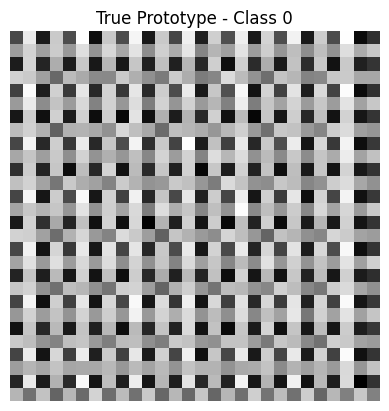

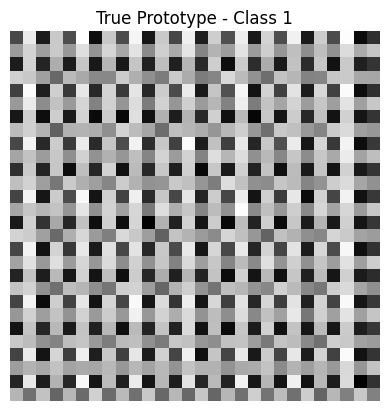

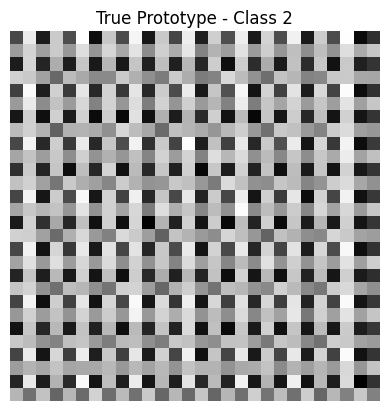

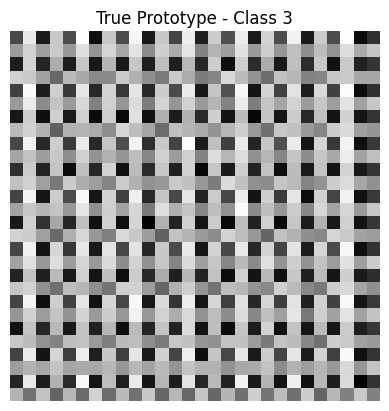

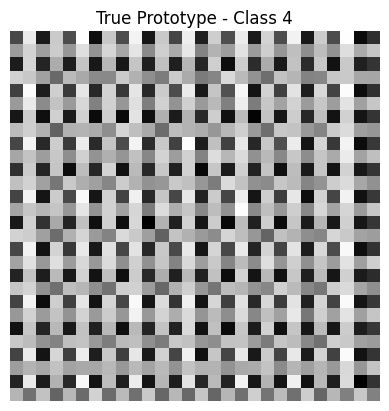

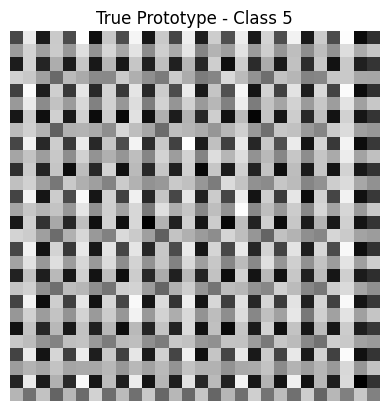

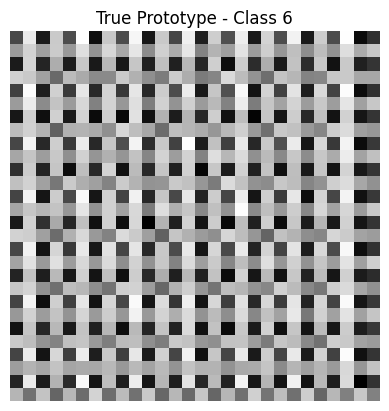

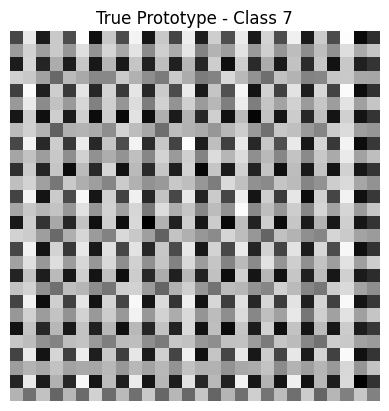

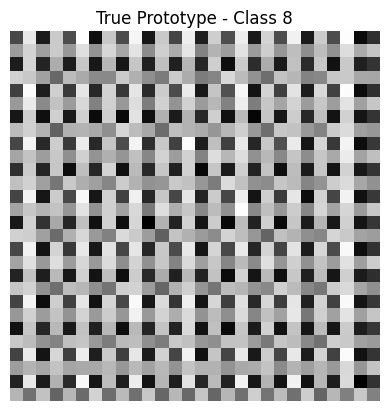

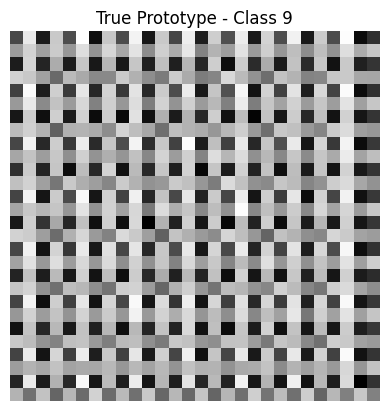

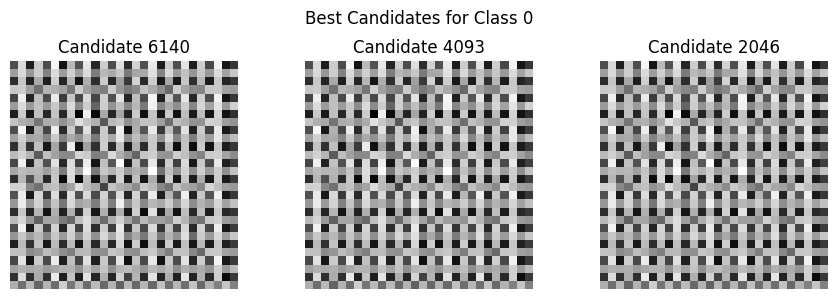

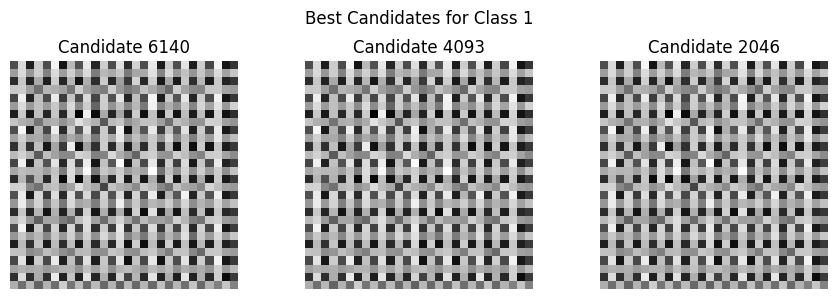

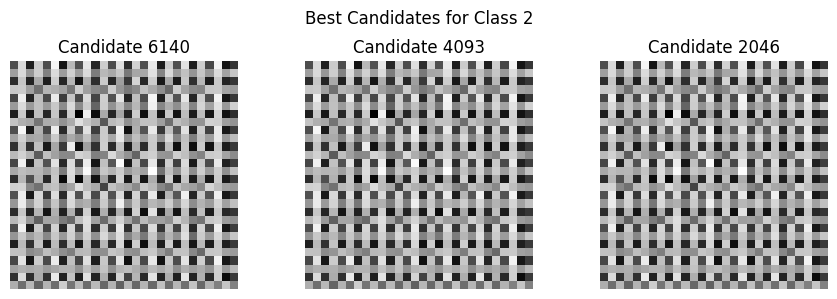

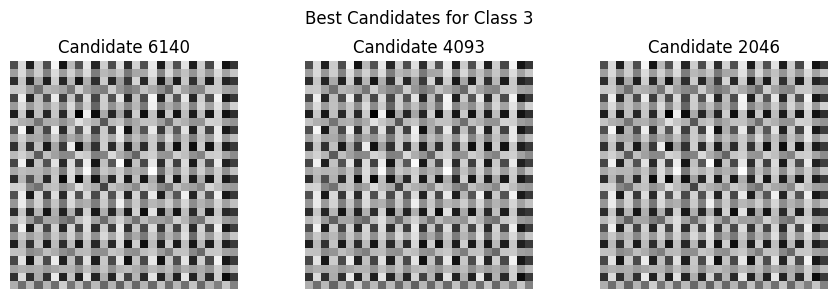

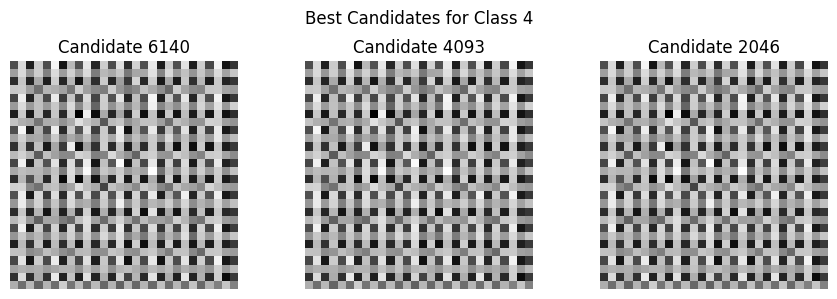

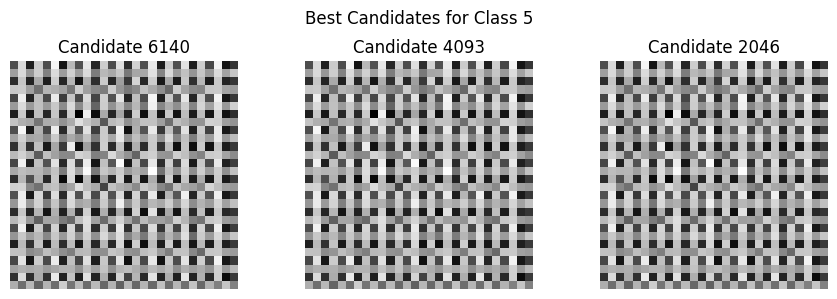

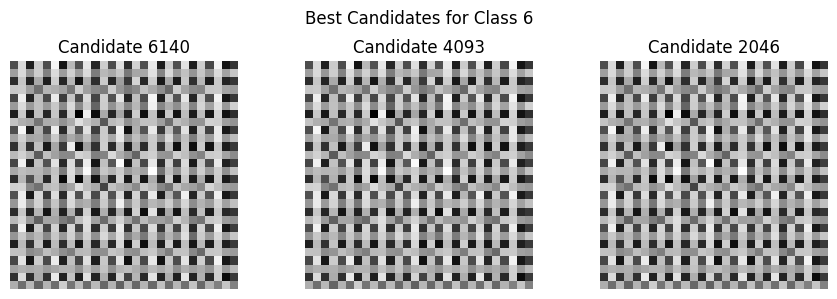

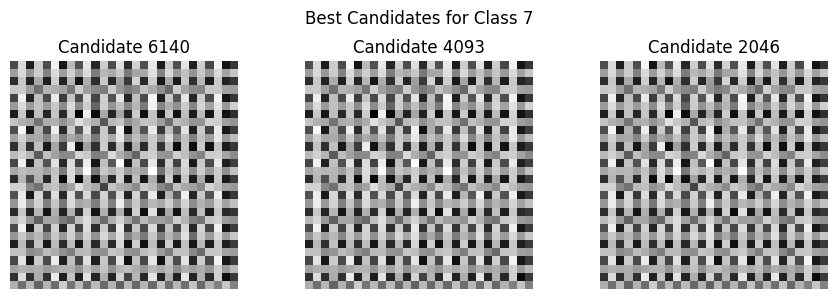

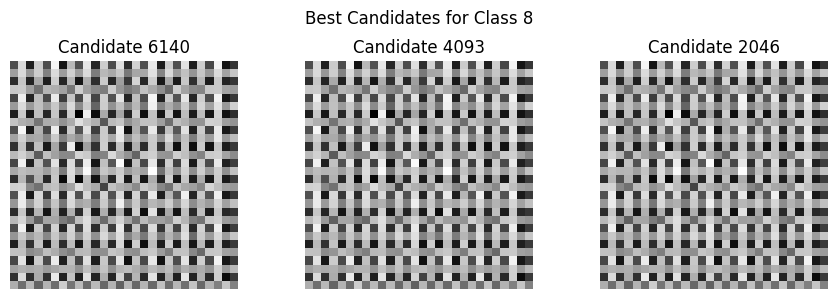

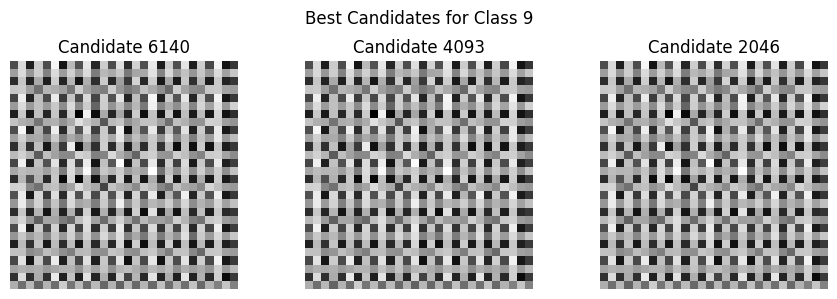

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_true_prototype(true_centroids, class_label, cobweb_model):
    """
    Visualize the true class centroid latent vector (for the given class) decoded into a 28x28 image.
    Assumes true_centroids[class_label] is a latent tensor of shape [n_hidden].
    """
    # Get the latent vector for this class and ensure it is on the correct device.
    centroid_tensor = true_centroids[class_label].unsqueeze(0).to(next(cobweb_model.parameters()).device)
    
    with torch.no_grad():
        # Pass the latent vector through the decoder_fc then reshape appropriately.
        decoded_features = cobweb_model.decoder_fc(centroid_tensor)
        decoded_features = decoded_features.view(-1, cobweb_model.out_channels, cobweb_model.H_conv, cobweb_model.W_conv)
        # Decode to reconstruct an image.
        reconstructed_img = cobweb_model.decoder(decoded_features).squeeze().cpu().numpy()
    
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f"True Prototype - Class {class_label}")
    plt.axis('off')
    plt.show()


def visualize_candidate_prototypes(best_candidates, candidate_centroids, class_label, cobweb_model):
    """
    Visualizes the selected candidate prototypes (from the tree nodes) for a given class.
    best_candidates: dictionary mapping a class label to a list of candidate indices.
    candidate_centroids: tensor of shape [num_candidates, n_hidden].
    """
    indices = best_candidates[class_label]
    num_candidates = len(indices)
    
    # Create subplots: one for each candidate.
    fig, axes = plt.subplots(1, num_candidates, figsize=(num_candidates * 3, 3))
    # In case there's only one candidate, axes might not be an iterable.
    if num_candidates == 1:
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        candidate_tensor = candidate_centroids[idx].unsqueeze(0).to(next(cobweb_model.parameters()).device)
        with torch.no_grad():
            decoded_features = cobweb_model.decoder_fc(candidate_tensor)
            decoded_features = decoded_features.view(-1, cobweb_model.out_channels, cobweb_model.H_conv, cobweb_model.W_conv)
            reconstructed_img = cobweb_model.decoder(decoded_features).squeeze().cpu().numpy()
        ax.imshow(reconstructed_img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Candidate {idx}")
    
    plt.suptitle(f"Best Candidates for Class {class_label}")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Visualization Calls
# -----------------------------
# Visualize all TRUE PROTOTYPES (one per class)
for c in range(10):
    visualize_true_prototype(true_centroids, class_label=c, cobweb_model=cobweb)

# Visualize BEST CANDIDATES for each class (from the matching step)
for c in range(10):
    visualize_candidate_prototypes(best_candidates, candidate_centroids, class_label=c, cobweb_model=cobweb)


In [ ]:
import matplotlib.pyplot as plt

def visualize_true_prototype(true_prototypes, class_label, cobweb_model):
    """
    Visualize the true class centroid latent vector decoded into a 28x28 image.
    """
    centroid = true_prototypes[class_label]  # This is a numpy array, must be converted to tensor
    centroid_tensor = torch.tensor(centroid, dtype=torch.float32, device=cobweb_model.leaves.device).unsqueeze(0)

    with torch.no_grad():
        reconstructed = cobweb_model.decoder_fc(centroid_tensor)
        reconstructed = reconstructed.view(-1, cobweb_model.out_channels, cobweb_model.H_conv, cobweb_model.W_conv)
        reconstructed_img = cobweb_model.decoder(reconstructed).squeeze().cpu().numpy()

    plt.imshow(reconstructed_img, cmap='gray')
    plt.title(f'True Prototype (Centroid) - Class {class_label}')
    plt.axis('off')
    plt.show()

# visualize_true_prototype(true_prototypes, class_label=0, cobweb_model=cobweb)

for i in range(10):
    visualize_true_prototype(true_prototypes, class_label=i, cobweb_model=cobweb)

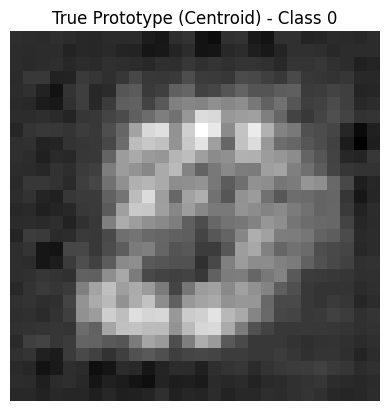

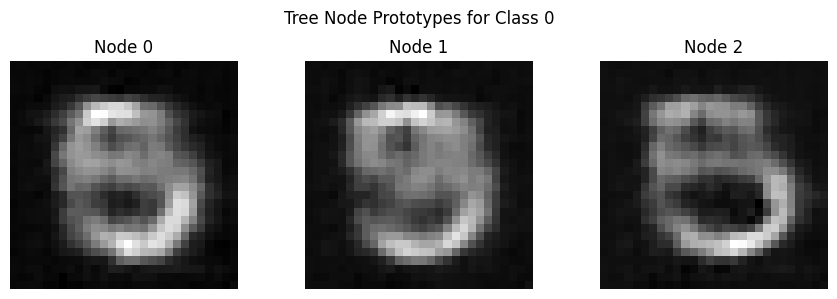

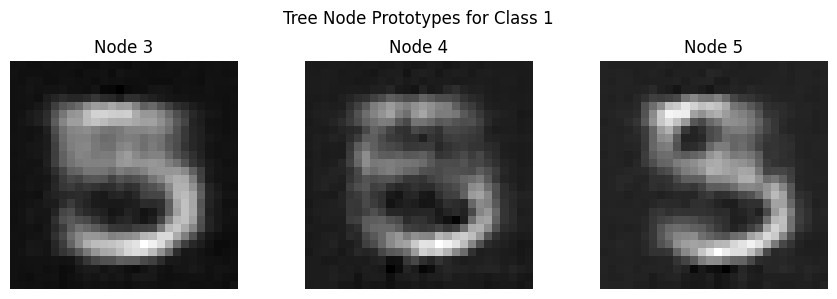

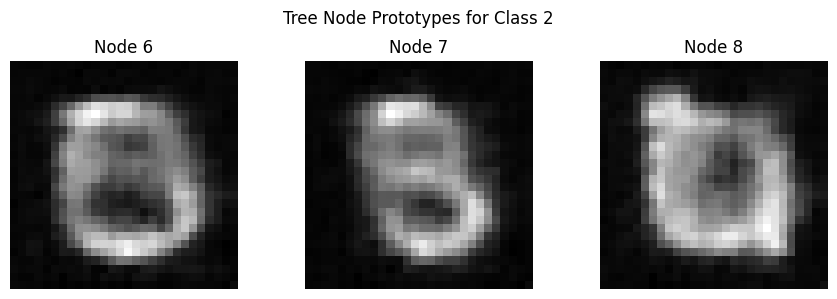

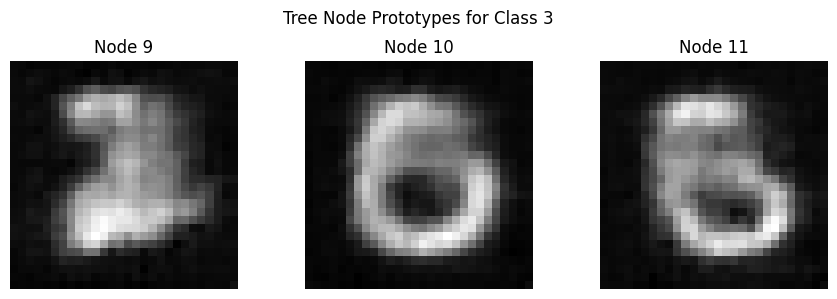

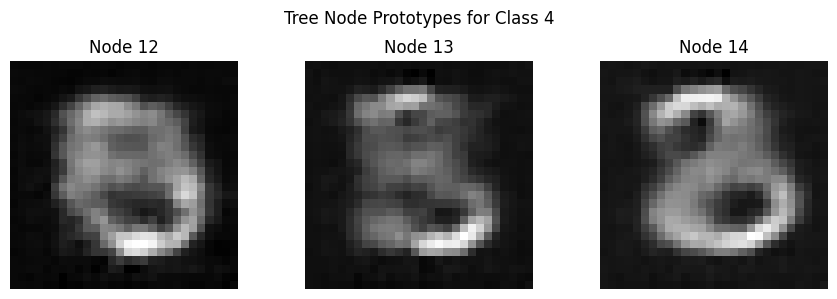

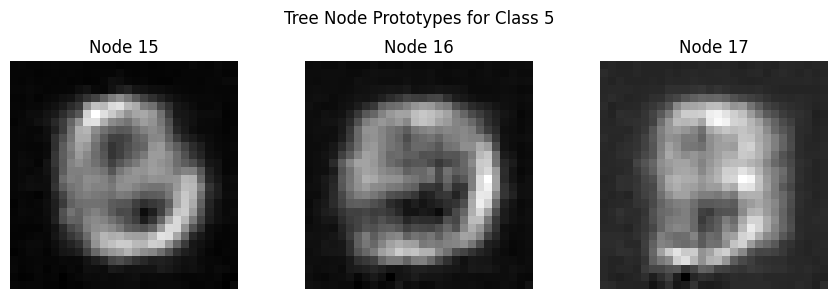

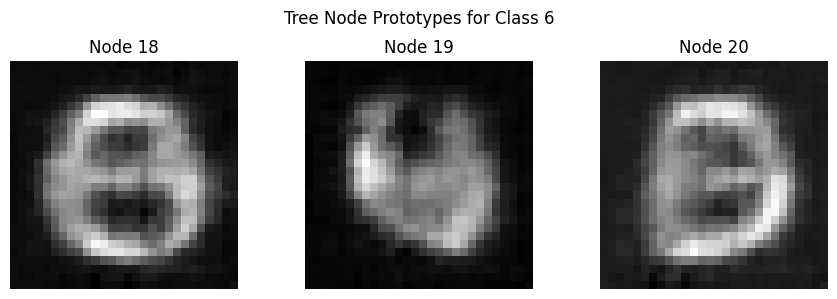

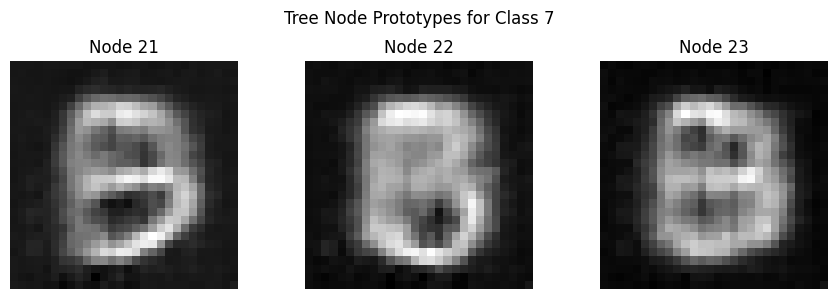

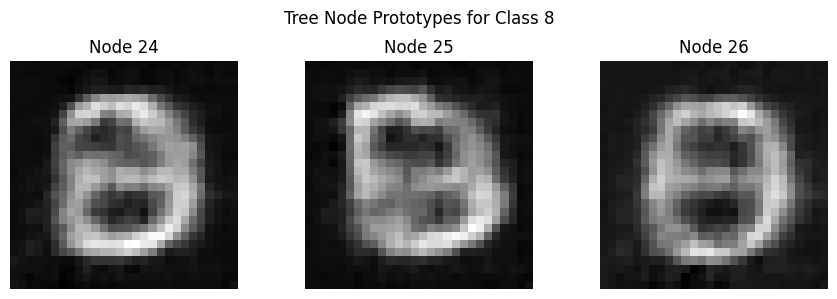

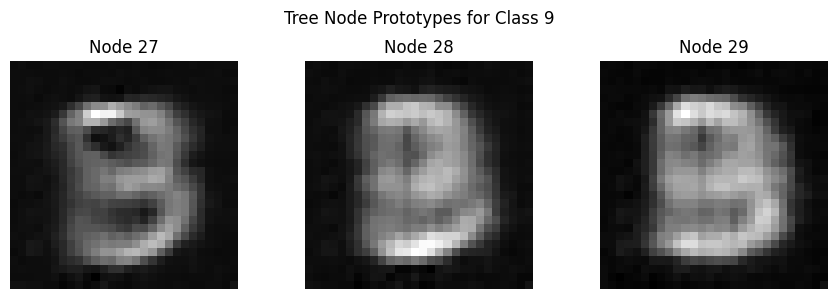

In [72]:
def visualize_tree_prototypes(prototypes, node_centroids, class_label, cobweb_model):
    """
    Visualizes the selected tree-node prototypes for the given class by decoding back to images.
    """
    indices = prototypes[class_label]

    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    fig.suptitle(f'Tree Node Prototypes for Class {class_label}')

    for ax, node_idx in zip(axes, indices):
        centroid_np = node_centroids[node_idx]
        centroid_tensor = torch.tensor(centroid_np, dtype=torch.float32, device=cobweb_model.leaves.device).unsqueeze(0)
        
        with torch.no_grad():
            reconstructed = cobweb_model.decoder_fc(centroid_tensor)
            reconstructed = reconstructed.view(-1, cobweb_model.out_channels, cobweb_model.H_conv, cobweb_model.W_conv)
            reconstructed_img = cobweb_model.decoder(reconstructed).squeeze().cpu().numpy()
            
        ax.imshow(reconstructed_img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Node {node_idx}')

    plt.tight_layout()
    plt.show()
    
visualize_true_prototype(true_prototypes, class_label=0, cobweb_model=cobweb)
for i in range(10):
    visualize_tree_prototypes(prototypes, node_centroids, class_label=i, cobweb_model=cobweb)

$ \textbf{TESTING ZONE BEWARE ERRORS }$

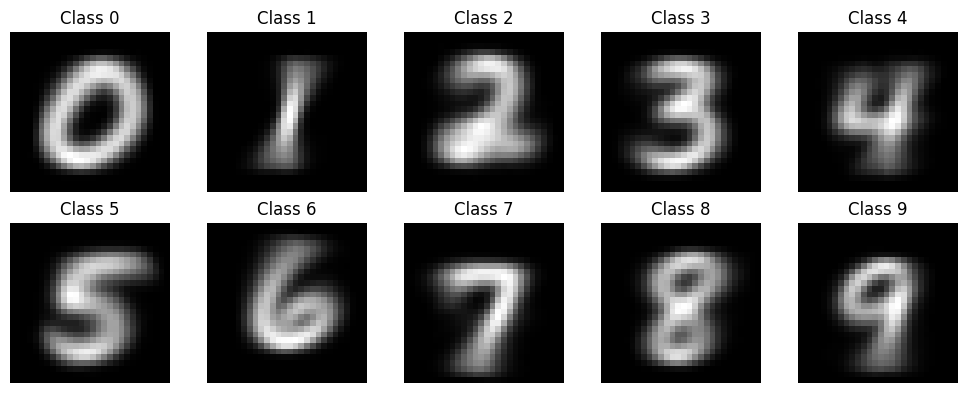

In [63]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the transformation to convert images to tensors.
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the MNIST test dataset (10k images)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Organize images by class using a dictionary.
images_by_class = defaultdict(list)
for image, label in test_dataset:
    images_by_class[label].append(image)

# Compute the centroid (pixel-wise average) for each class.
centroids = {}
for label, images in images_by_class.items():
    # Stack images into a single tensor of shape (num_images, 1, 28, 28)
    stacked_images = torch.stack(images)
    # Compute the average image across the first dimension.
    centroid = stacked_images.mean(dim=0)  # shape becomes (1, 28, 28)
    centroids[label] = centroid.squeeze(0)  # remove the channel dimension for visualization

# Plot the centroids in a 2x5 grid.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()
for digit in range(10):
    ax = axes[digit]
    # Convert tensor to numpy array for imshow.
    ax.imshow(centroids[digit].numpy(), cmap='gray')
    ax.set_title(f'Class {digit}')
    ax.axis('off')  # Remove axes for clarity

plt.tight_layout()
plt.show()
